# Australian Forest Observatory
## Field Validation

### Field sampling method:

53 sites x three 20 m transects per site
  - Central: 67 transects
  - Pilliga: 31 transects
  - Snowy Mountains: 61 transects

Field data collected per 20 m transect
- Litter depth: (mm) x 10
- Litter cover: (presence/absence) x 10
- Near surface fuel height: (m) x 10
- Near surface fuel: (presence/absence) x 10
- Elevated fuel height: (m) x 10
- Elevated fuel: (presence/absence) x 10
- Canopy height: (m) x 5
- Canopy cover: (%) x 5
- Bark type: x 1
- Bark hazard rating:  x 1
- Photos: x heaps

for more detain on sampling strategy and execution see:
[Sampling Strategy](/docs/Proposed%20Sampling%20StrategyV3.docx)

### data exploration
for flexible formulae for data exploration scroll down to last couple of code cells (after running all cells - takes about 1 min).

## Setup
set up the python environment. The required modules can be installed using:

`> python -m pip install -r requirements.txt`

In [1]:
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
import pandas as pd
from shapely.geometry import Point
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from pandas import DataFrame, Series
from matplotlib.pyplot import Axes
from osgeo import gdal

setup lookup tables for dataframe management and graphing utilities

In [2]:
# superset of column names
all_cols = {
    'globalid': ['id', 'Unique Site ID'],
    'Site': ['site', 'Site No'],
    'plot': ['plot', 'Plot No'], 
    'Date': ['date', 'Date'], 
    'Name': ['observer', 'Assessor Name'], 
    'Fuel': ['veg_type', 'Vegetation Class'],
    'FireHistor': ['fire_hist', 'Time since Fire (y)'], 
    'latitude': ['lat', 'Latitude (°)'], 
    'longitude': ['lon', 'Longitude (°)'],
    'horaccmete': ['loc_accuracy', 'Location accuracy (m)'],
    'FuelDepth1': ['litter_d_1', 'Litter Depth: Sample 1 (mm)'],
    'Cover1': ['litter_state_1', 'Litter State: Sample 1 (presence/absence)'], 
    'NearSurfac': ['ns_h_1', 'Near surface fuel height: Sample 1 (m)'],
    'NearSurf_1': ['ns_state_1', 'Near surface fuel state: Sample 1 (absent/alive/dead)'],
    'Elevated1': ['elev_h_1', 'Elevated fuel height: Sample 1 (m)'],
    'ElevatedCo': ['elev_state_1', 'Elevated fuel state: Sample 1 (absent/alive/dead)'],
    'CanopyHeig': ['canopy_h_1', 'Canopy height: Sample 1 (m)'],
    'CanopyCove': ['canopy_cov_1', 'Canopy cover: Sample 1 (%)'],
    'FuelDepth2': ['litter_d_2', 'Litter Depth: Sample 2 (mm)'], 
    'Cover2': ['litter_state_2', 'Litter State: Sample 2 (presence/absence)'],
    'NearSurf_2': ['ns_h_2', 'Near surface fuel height: Sample 2 (m)'], 
    'NearSurf_3': ['ns_state_2', 'Near surface fuel state: Sample 2 (absent/alive/dead)'],
    'Elevated2': ['elev_h_2', 'Elevated fuel height: Sample 2 (m)'],
    'Elevated_1': ['elev_state_2', 'Elevated fuel state: Sample 2 (absent/alive/dead)'],
    'FuelDepth3': ['litter_d_3', 'Litter Depth: Sample 3 (mm)'],
    'Cover3': ['litter_state_3', 'Litter State: Sample 3 (presence/absence)'],
    'NearSurf_4': ['ns_h_3', 'Near surface fuel height: Sample 3 (m)'],
    'NearSurf_5': ['ns_state_3', 'Near surface fuel state: Sample 3 (absent/alive/dead)'],
    'Elevated3': ['elev_h_3', 'Elevated fuel height: Sample 3 (m)'],
    'Elevated_2': ['elev_state_3', 'Elevated fuel state: Sample 3 (absent/alive/dead)'],
    'CanopyHe_1': ['canopy_h_3', 'Canopy height: Sample 3 (m)'],
    'CanopyCo_1': ['canopy_cov_3', 'Canopy cover: Sample 3 (%)'],
    'FuelDepth4': ['litter_d_4', 'Litter Depth: Sample 4 (mm)'],
    'Cover4': ['litter_state_4', 'Litter State: Sample 4 (presence/absence)'],
    'NearSurf_6': ['ns_h_4', 'Near surface fuel height: Sample 4 (m)'],
    'NearSurf_7': ['ns_state_4', 'Near surface fuel state: Sample 4 (absent/alive/dead)'],
    'Elevated4': ['elev_h_4', 'Elevated fuel height: Sample 4 (m)'],
    'Elevated_3': ['elev_state_4', 'Elevated fuel state: Sample 4 (absent/alive/dead)'],
    'FuelDepth5': ['litter_d_5', 'Litter Depth: Sample 5 (mm)'],
    'Cover5': ['litter_state_5', 'Litter State: Sample 5 (presence/absence)'],
    'NearSurf_8': ['ns_h_5', 'Near surface fuel height: Sample 5 (m)'],
    'NearSurf_9': ['ns_state_5', 'Near surface fuel state: Sample 5 (absent/alive/dead)'],
    'Elevated5': ['elev_h_5', 'Elevated fuel height: Sample 5 (m)'],
    'Elevated_4': ['elev_state_5', 'Elevated fuel state: Sample 5 (absent/alive/dead)'],
    'CanopyHe_2': ['canopy_h_5', 'Canopy height: Sample 5 (m)'],
    'CanopyCo_2': ['canopy_cov_5', 'Canopy cover: Sample 5 (%)'],
    'FuelDepth6': ['litter_d_6', 'Litter Depth: Sample 6 (mm)'],
    'Cover6': ['litter_state_6', 'Litter State: Sample 6 (presence/absence)'],
    'NearSur_10': ['ns_h_6', 'Near surface fuel height: Sample 6 (m)'],
    'NearSur_11': ['ns_state_6', 'Near surface fuel state: Sample 6 (absent/alive/dead)'],
    'Elevated6': ['elev_h_6', 'Elevated fuel height: Sample 6 (m)'],
    'Elevated_5':['elev_state_6', 'Elevated fuel state: Sample 6 (absent/alive/dead)'],
    'FuelDepth7': ['litter_d_7', 'Litter Depth: Sample 7 (mm)'],
    'Cover7': ['litter_state_7', 'Litter State: Sample 7 (presence/absence)'],
    'NearSur_12': ['ns_h_7', 'Near surface fuel height: Sample 7 (m)'],
    'NearSur_13': ['ns_state_7', 'Near surface fuel state: Sample 7 (absent/alive/dead)'],
    'Elevated7': ['elev_h_7', 'Elevated fuel height: Sample 7 (m)'],
    'Elevated_6': ['elev_state_7', 'Elevated fuel state: Sample 7 (absent/alive/dead)'],
    'CanopyHe_3': ['canopy_h_7', 'Canopy height: Sample 7 (m)'],
    'CanopyCo_3': ['canopy_cov_7', 'Canopy cover: Sample 7 (%)'],
    'FuelDepth8': ['litter_d_8', 'Litter Depth: Sample 8 (mm)'], 
    'Cover8': ['litter_state_8', 'Litter State: Sample 8 (presence/absence)'],
    'NearSur_14': ['ns_h_8', 'Near surface fuel height: Sample 8 (m)'],
    'NearSur_15': ['ns_state_8', 'Near surface fuel state: Sample 8 (absent/alive/dead)'],
    'Elevated8': ['elev_h_8', 'Elevated fuel height: Sample 8 (m)'],
    'Elevated_7': ['elev_state_8', 'Elevated fuel state: Sample 8 (absent/alive/dead)'],
    'FuelDepth9': ['litter_d_9', 'Litter Depth: Sample 9 (mm)'],
    'Cover9': ['litter_state_9', 'Litter State: Sample 9 (presence/absence)'],
    'NearSur_16': ['ns_h_9', 'Near surface fuel height: Sample 9 (m)'],
    'NearSur_17': ['ns_state_9', 'Near surface fuel state: Sample 9 (absent/alive/dead)'],
    'Elevated9': ['elev_h_9', 'Elevated fuel height: Sample 9 (m)'],
    'Elevated_8': ['elev_state_9', 'Elevated fuel state: Sample 9 (absent/alive/dead)'],
    'CanopyHe_4': ['canopy_h_9', 'Canopy height: Sample 9 (m)'],
    'CanopyCo_4': ['canopy_cov_9', 'Canopy cover: Sample 9 (%)'],
    'FuelDept_1': ['litter_d_10', 'Litter Depth: Sample 10 (mm)'],
    'Cover10': ['litter_state_10', 'Litter State: Sample 10 (presence/absence)'],
    'NearSur_18': ['ns_h_10', 'Near surface fuel height: Sample 10 (m)'],
    'NearSur_19': ['ns_state_10', 'Near surface fuel state: Sample 10 (absent/alive/dead)'],
    'Elevated10': ['elev_h_10', 'Elevated fuel height: Sample 10 (m)'],
    'Elevated_9': ['elev_state_10', 'Elevated fuel state: Sample 10 (absent/alive/dead)'],
    'AverageFue': ['litter_d_m', 'Mean litter depth (mm)'],
    'AverageSur': ['litter_state_count', 'Litter cover P/A count (/10)'],
    'AveragePer': ['litter_cov', 'Litter cover (%)'],
    'FuelLoad': ['litter_load', 'Litter fuel load (t/ha)'],
    'Fuel_Hazar': ['s_fhr', 'Surface fuel hazard rating'], 
    'averageNSh': ['ns_h_m', 'Mean near surface height (m)'], 
    'averageNSc': ['ns_state_count', 'Near Surface P/A count (/10)'], 
    'averageN_1': ['ns_cov', 'Near surface cover (%)'], 
    'averageNSd': ['ns_dead_count', 'Near surface dead count'], 
    'percentage': ['ns_dead_%', 'Near surface dead as percentage of near surface present'], 
    'nearsur_20': ['_ns_fhr', 'Near surface Fuel Hazard Rating'], # repeat?
    'Near_Surfa': ['ns_fhr', 'Near surface Fuel Hazard Rating'], 
    'nearsur_21': ['ns_load', 'Near surface fuel load (t/ha)'], 
    'combined': ['s&ns_fhr', 'Combined surface and near surface Fuel Hazard Rating'], 
    'averageele': ['elev_h_m', 'Mean elevated height (m)'], 
    'averagee_1': ['elev_state_count', 'Elevated P/A count (/10)'], 
    'averagee_2': ['elev_cov', 'elevated cover (%)'], 
    'averagee_3': ['elev_dead_count', 'Elevated dead count'],
    'elevatedpe': ['elev_dead_%', 'elevated dead as percentage of elevated present'], 
    'elevated_f': ['_elev_fhr', 'Elevated Fuel Hazard Rating'], # repeat?
    'elevated_h': ['elev_fhr', 'Elevated Fuel Hazard Rating'], 
    'elevate_10': ['elev_load', 'Elevated fuel load (t/ha)'], 
    'bark_type': ['bark_type', 'Bark type'], 
    'bark_fuel': ['bark_haz&type', 'Bark hazard rating and type'], 
    'bark_hazar': ['bark_haz', 'Bark hazard rating'], 
    'bark_fuell': ['bark_load', 'Bark fuel load (t/ha)'], 
    'height_ave': ['canopy_h_m', 'Mean canopy height (m)'], 
    'cannopy_av':['canopy_cov_m', 'Mean canopy cover (%)'], 
    'plotgood': ['representative', 'Plot is representative of area (Y/N)'], 
    'comments': ['comments', 'Comments'],
    'geometry': ['geometry', 'Shapefile geometry'],
}

# column names and descriptions
# new df columns need to be added to this list to ensure automated routines
# execute properly
# labels['new_col_name'] = "New Data Description (units)"
labels = {
    'afo_cc': 'AFO Crown Cover %',
    'afo_lfd': 'AFO Ladder Fuel Density',
    'afo_ch': 'AFO Canopy Height (m)',
    'afo_cbh': 'AFO Canopy Base Height (m)',
    'afo_litter': 'AFO litter fuel load (t/ha)', 
    'afo_surface': 'AFO surface fuel load (t/ha)', 
    'afo_elevated': 'AFO elevated fuel  load (t/ha)', 
    'afo_bark': 'AFO bark fuel load (t/ha)'
}

# smaller working set of data - extraneous columns removed
# new column names can be added as desired
subset = [
    'id', 'site', 'plot', 'observer', 'veg_type', 'fire_hist', 'loc_accuracy', 
    'litter_d_m', 'litter_cov', 'litter_load', 's_fhr', 
    'ns_h_m', 'ns_cov', 'ns_load', 'ns_fhr', 
    's&ns_fhr', 
    'elev_h_m', 'elev_cov', 'elev_load', 'elev_fhr', 
    'bark_type', 'bark_load', 'bark_haz', 
    'canopy_h_m', 'canopy_cov_m', 
    'representative', 'comments', 'geometry'
]

# afo columns to be used for correlation tables
afo_keys = [
    'afo_cc', 'afo_lfd', 'afo_ch', 'afo_cbh', 'afo_litter', 
    'afo_surface', 'afo_elevated', 'afo_bark',     
]

# field data columns to be used for correlations
field_keys = [
    'litter_d_m', 'litter_cov', 'litter_load', 'ns_h_m', 'ns_cov', #'ns_load', 
    'elev_h_m', 'elev_cov', 'elev_load', 'bark_load', 
    'canopy_h_m', 'canopy_cov_m',
]

#site name prefixes and corresponding regions
regions = {'EC': 'central', 'P': 'pilliga', 'SM': 'snowy'}

helper functions

In [3]:
#set latex strings to be used on graphs etc
rsq_str = r'$r^2$' #r_squared doh!

# helper functions
def mae(observed: Series, predicted: Series) -> float:
    """mean absolute error."""
    return np.mean(np.abs(observed - predicted))

def rmse(observed: Series, predicted: Series) -> float:
    """root mean squared error"""
    return np.sqrt(np.mean((predicted - observed) ** 2))

def read_afo(paths: dict, coord_df: GeoDataFrame, index: int = None, offset: int = 0) -> Series:
    """samples single and multiband AFO geotiffs.

    Combines data from separate regions.

    Args:
        paths (dict): of the form {'region_names': 'relative_path_to_geotiff'
        coord_df (GeoDataFrame): gdf containing sample coordinates as `geometry`
        index (int, optional): for multiband data the index of the band to sample
        offset (int, optional): offsets sample `offset` units to west to test 
            robustness of sampling to location.

    Returns:
        Series: sampled data
    """

    coord_df = coord_df[['geometry']]
    for region, path in paths.items():
        with rasterio.open(path, 'r') as src:
            print(f'Input CRS is: {src.crs}')
            coord_df = coord_df.to_crs(src.crs)
            site_coords = [
                (x,y) for x,y in zip(
                    coord_df['geometry'].x - offset, coord_df['geometry'].y
                )
            ]
            coord_df[region] = -9999
            if index is None:
                coord_df[region] = [x for x in src.sample(site_coords)]
            else:
                coord_df[region] = [x[index] for x in src.sample(site_coords)]
    
    return coord_df[paths.keys()].max(axis=1)

def read_rfs(path: str, coord_df: GeoDataFrame) -> Series:
    """reads RFS corporate data in geotiff form

    Args:
        path (str): path to the geotiff file
        coord_df (GeoDataFrame): gdf containing sample coordinates as `geometry`

    Returns:
        Series: sampled data
    """
    coord_df = coord_df[['geometry']]
    with rasterio.open(path, 'r') as src:
        print(f'Input CRS is: {src.crs}')
        coord_df = coord_df.to_crs(src.crs)
        site_coords = [
            (x,y) for x,y in zip(coord_df['geometry'].x, coord_df['geometry'].y)
        ]
        coord_df['sample_data'] = [x[0] for x in src.sample(site_coords)]
    return coord_df['sample_data']

def reg_plot(x: str, y: str, df: DataFrame, hue: str=None, line:bool = True) -> Axes:
    """Regression plot with stats. Points coloured by `hue`.

    adds the following statistical data: r_sq, MAE, RMSE

    Args:
        x (str): df column name for x values
        y (str): df column name for y values
        df (DataFrame): dataframe containing the x, y data
        hue (str): df column name to use to colour the values. Defaults to `None`
        line (bool): if `True` will draw 1:1 line in data units. Defaults 
            to `False`

    Returns:
        Axes: matplotlib axes  
    """
    _df = df[[x, y]].dropna()
    slope, intercept, r_value, p_value, std_err = linregress(_df[x], _df[y])
    _mae = mae(df[x], df[y])
    _rmse = rmse(df[x], df[y])
    stats = f'{rsq_str}: {r_value**2:.2f} \n MAE: {_mae:.2f} \n RMSE: {_rmse:.2f}'
    grid = sns.lmplot(x=x, y=y, data=df, hue=hue, fit_reg=False, height=8, aspect=1.5)
    ax = grid.axes[0, 0]
    sns.regplot(x=x, y=y, data=df, scatter=False, ax=ax)
    ax.text(0.1, 0.9, stats, ha='center', va='center', transform=ax.transAxes)
    ax.set(xlabel=labels[x], ylabel=labels[y])
    if line: ax.axline([0, 0], [1, 1], color='grey')
    
    return ax

def reg_plots(x: str, y: str, df: DataFrame, hue: str=None, line:bool = True) -> sns.FacetGrid:
    """creates a series of linear regression with axis labels and calculates
    descriptive statistics.

    Args:
        x (str): df column name for x values
        y (str): df column name for y values
        df (DataFrame):
        hue (str, optional): df column name to define subsets. Defaults to `None`.
    """
    subsets = set(df[hue])
    subsets.discard(None)
    regressions = sns.FacetGrid(df, col=hue, col_order=subsets, hue=hue, height=5, aspect=1.2, col_wrap=2)
    regressions.map(sns.regplot, x, y)
    regressions.set_ylabels(labels[y])
    regressions.set_xlabels(labels[x])
    
    for ax, subset in zip(regressions.axes.flat, subsets):
        _df = df.loc[df[hue]==subset]
        _df = _df[[x, y]].dropna()
        if _df.shape[0] > 5: # make sure _df not too small
            slope, intercept, r_value, p_value, std_err = linregress(_df[x], _df[y], )
            _mae = mae(_df[x], _df[y])
            _rmse = rmse(df[x], df[y])
            stats = f'{rsq_str}: {r_value**2:.2f} \n MAE: {_mae:.2f} \n RMSE: {_rmse:.2f}'
            ax.text(0.15, 0.9, stats, ha='center', va='center', transform=ax.transAxes)
            if line: ax.axline([0, 0], [1, 1], color='grey')
    
    return regressions

def rasters_resample(path_dict: dict, res: float) -> dict:
    """resamples geotiffs to resolution = `res`.

    Args:
        path_dict (dict): dictionary containing path to input geotifs.
        res (float): resolution in projected units of resultant geotiff

    Returns:
        dict: dictionary containing path to input geotifs.
    """
    out_paths = {}
    for key, path in path_dict.items():
        outpath = f'{path.split(".")[0]}_{res}.tif'
        gdal.Translate(
            outpath, path,
            options=f'-of GTiff -tr {res} {res} -r bilinear'
        )
        out_paths[key] = outpath 
    return out_paths

def add_regions(dic: dict, gdf: GeoDataFrame) -> Series:
    """Adds region classes to the dataframe based on site name.

    The default region is 'Other'

    Args:
        dic (dict): of the form {'site_prefix': 'region_name'} where 
            `site_prefix` is the begining of the site name for that region.
            eg. {'EC': 'central'}
        df (GeoDataFrame): source data

    Returns:
        Series: 
    """
    df = gdf.copy(deep=True)
    df['region'] = 'Other'
    for key, region in dic.items():
        df['region'] = df['region'].where(~df['site'].str.startswith(key), region)
    return df['region']


read the field sampling geodata

In [4]:
path = 'spatial_data/Field_Data/AFO_Field_Samples_20220331.shp'
gdf = gpd.read_file(path)
gdf = gdf[gdf['geometry'].x > 0] # drop sites with no location data
gdf.shape

(159, 129)

rename columns to something meaningful (associated with longer description in dictionary)

In [5]:
rename_dict = {} # used to cut down and rename columns
for key, [field, desc] in all_cols.items():
    rename_dict[key] = field
    labels[field] = desc
gdf = gdf.rename(columns=rename_dict)
gdf.shape

(159, 129)

the survey app deals poorly with missing data so recalculate means and percentages for relevant fields

In [6]:
quantitative_fields = ['canopy_cov', 'canopy_h', 'elev_h', 'litter_d', 'ns_h']
presence_absence_fields = ['elev_state', 'litter_state', 'ns_state']

for field in quantitative_fields:
    cols = [string for string in list(gdf.columns.values) if field in string]
    gdf[f'{field}_m'] = gdf[cols[:-1]].mean(axis=1)

for field in presence_absence_fields:
    cols = [string for string in list(gdf.columns.values) if field in string]
    gdf[f'{field}_count'] = (
        gdf[gdf[cols[:-1]] == 'alive'].count(axis=1) + 
        gdf[gdf[cols[:-1]] == 'dead'].count(axis=1) + 
        gdf[gdf[cols[:-1]] == 'yes'].count(axis=1)
    )
    prefix=field.split('_')[0]
    gdf[f'{prefix}_cov'] = gdf[f'{field}_count']*10

gdf.shape

(159, 129)

cut down the number of columns, and sort it just because it makes it nice :)

In [7]:
gdf = gdf[subset]
gdf.sort_values(by=['site', 'plot'], inplace=True)
gdf.shape

(159, 28)

shapefile data are imported as objects so need to convert to data types that will be used for correlation and other analyses

In [8]:
gdf= gdf.replace('BlanK', np.nan) # some missing values

numeric = [
    'litter_d_m', 'litter_cov', 'litter_load', 
    'ns_h_m', 'ns_cov', 'ns_load', 
    'elev_h_m', 'elev_cov', 'elev_load', 
    'bark_load', 
    'canopy_h_m', 'canopy_cov_m', 
]

for col in numeric:
    gdf[col] = pd.to_numeric(gdf[col])
gdf.dtypes

id                  object
site                object
plot                object
observer            object
veg_type            object
fire_hist           object
loc_accuracy       float64
litter_d_m         float64
litter_cov           int64
litter_load        float64
s_fhr               object
ns_h_m             float64
ns_cov               int64
ns_load            float64
ns_fhr              object
s&ns_fhr            object
elev_h_m           float64
elev_cov             int64
elev_load            int64
elev_fhr            object
bark_type           object
bark_load            int64
bark_haz            object
canopy_h_m         float64
canopy_cov_m       float64
representative      object
comments            object
geometry          geometry
dtype: object

## Sample the AFO geotiffs

It seems that all the geotiffs are all projected using the MGA zone 56 crs (EPSG:32756) regardless of what zone they are in but let's check this as we read them.

With a bit of python dictionary magic we should be able to do this as a batch lot!

The dictionaries contain a list of strata - these are just names given to the different bands of multiband geotiffs. For single band data just repeat the column label.

In [9]:
afo = {} # column names and paths
#crown cover
cc_paths = {
    'pilliga': 'spatial_data/Pilliga-vegetation-canopy_cover-2021.tif',
    'central': 'spatial_data/Centralcoast-vegetation-canopy_cover-2021.tif',
    'snowy': 'spatial_data/Southmnts-vegetation-canopy_cover-2021.tif',
}
afo['afo_cc'] = cc_paths, ['afo_cc'] #second element is list of strata

# ladder fuel density
lfd_paths = {
    'pilliga': 'spatial_data/Pilliga-vegetation-ladder_fuel_density-2021.tif',
    'central': 'spatial_data/Centralcoast-vegetation-ladder_fuel_density-2021.tif',
    'snowy': 'spatial_data/Southmnts-vegetation-ladder_fuel_density-2021.tif',
}
afo['afo_lfd'] = lfd_paths, ['afo_lfd']

# canopy height
ch_paths = {
    'pilliga': 'spatial_data/Pilliga-vegetation-canopy_height-2021.tif',
    'central': 'spatial_data/Centralcoast-vegetation-canopy_height-2021.tif',
    'snowy': 'spatial_data/Southmnts-vegetation-canopy_height-2021.tif',
}
afo['afo_ch'] = ch_paths, ['afo_ch']

# canopy base height
cbh_paths = {
    'pilliga': 'spatial_data/Pilliga-vegetation-canopy_base_height-2021.tif',
    'central': 'spatial_data/Centralcoast-vegetation-canopy_base_height-2021.tif',
    'snowy': 'spatial_data/Southmnts-vegetation-canopy_base_height-2021.tif',
}
afo['afo_cbh'] = cbh_paths, ['afo_cbh']

# fuel loads
fuel_load_paths = {
    'pilliga': 'spatial_data/Pilliga-fuels-classes-2021-density.tif',
    'central': 'spatial_data/Centralcoast-fuels-classes-2021-density.tif',
    'snowy': 'spatial_data/Southmnts-fuels-classes-2021-density.tif',
}
afo['afo_fuel'] = fuel_load_paths, ['afo_litter', 'afo_surface', 'afo_elevated', 'afo_bark']

for layer, val in afo.items():
    path_dict, strata = val
    for band, stratum in enumerate(strata):
        gdf[stratum] = read_afo(path_dict, gdf, index=band)

gdf.head()


Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756


,id,site,plot,observer,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,litter_load,...,comments,geometry,afo_cc,afo_lfd,afo_ch,afo_cbh,afo_litter,afo_surface,afo_elevated,afo_bark
16,ccfa3f44-ca62-46fd-bc88-e41f28247cd3,EC10,1,Laurence McCoy,DSF,2,4.658635,19.0,100,5.00,...,None,POINT (151.28407 -33.58385),50.941280,10.934896,5.625101,2.781175,17.716690,17.716690,1.855503,3.123432
25,4d19111d-9db7-4087-9fff-627dbf92f9f4,EC10,2,Laurence McCoy,DSF,2,4.646899,11.0,40,2.50,...,None,POINT (151.28377 -33.58408),53.012089,8.507341,6.257932,3.228979,17.689646,17.689646,1.800139,3.030236
27,9f8027da-efe2-4dbd-a281-9685e01b3fc6,EC10,3,Laurence McCoy,DSF,2,4.675196,11.0,10,1.25,...,None,POINT (151.28358 -33.58432),36.591705,15.579016,3.823408,3.203048,17.148125,17.148125,1.230490,2.071327
33,65096dd3-a842-4875-abf6-755ee5c25a0b,EC11,1,Derek Meaghan,DSF,None,4.666925,31.0,100,15.00,...,None,POINT (151.04107 -34.16956),75.615562,5.986450,8.028476,3.168698,14.341352,16.307968,5.523356,2.643521
34,f4731772-5879-4fa8-b69f-9f0fe8e53adc,EC11,2,Derek Meaghan,DSF,None,4.668194,24.0,80,5.00,...,None,POINT (151.04137 -34.16933),82.196129,3.869198,9.999367,4.333815,14.651359,16.660486,6.413480,3.069542


load the time since fire data

In [10]:
gdf['rfs_tsf'] = read_rfs('spatial_data/RFS/RFS_TSF_202109201.tif',gdf)
labels['rfs_tsf'] = 'RFS Time Since Fire (y) 02109201'
gdf.shape

Input CRS is: EPSG:3308


(159, 37)

Add region labels

In [11]:
gdf['region'] = add_regions(regions, gdf)
gdf.shape

(159, 38)

test how sensitive the AFO data are to location by resampling with every point shifted 20 m to west. Here we just use the canopy cover but using the batch processing above we could do it for several/all AFO layers

In [12]:
gdf['afo_cc_off'] = read_afo(cc_paths, gdf, offset=20)
labels['afo_cc_off'] = 'AFO Canopy Cover offset 20 m'

Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756


resample to 30m

In [13]:
# resample the geotiffs
res = 30
afo_30m = {}
for layer, val in afo.items():
    path_dict = val[0]
    afo_30m[layer] = rasters_resample(path_dict, res), val[1]
afo_30m

{'afo_cc': ({'pilliga': 'spatial_data/Pilliga-vegetation-canopy_cover-2021_30.tif',
   'central': 'spatial_data/Centralcoast-vegetation-canopy_cover-2021_30.tif',
   'snowy': 'spatial_data/Southmnts-vegetation-canopy_cover-2021_30.tif'},
  ['afo_cc']),
 'afo_lfd': ({'pilliga': 'spatial_data/Pilliga-vegetation-ladder_fuel_density-2021_30.tif',
   'central': 'spatial_data/Centralcoast-vegetation-ladder_fuel_density-2021_30.tif',
   'snowy': 'spatial_data/Southmnts-vegetation-ladder_fuel_density-2021_30.tif'},
  ['afo_lfd']),
 'afo_ch': ({'pilliga': 'spatial_data/Pilliga-vegetation-canopy_height-2021_30.tif',
   'central': 'spatial_data/Centralcoast-vegetation-canopy_height-2021_30.tif',
   'snowy': 'spatial_data/Southmnts-vegetation-canopy_height-2021_30.tif'},
  ['afo_ch']),
 'afo_cbh': ({'pilliga': 'spatial_data/Pilliga-vegetation-canopy_base_height-2021_30.tif',
   'central': 'spatial_data/Centralcoast-vegetation-canopy_base_height-2021_30.tif',
   'snowy': 'spatial_data/Southmnts-veg

In [15]:
# read resampled tifs into dataframe
gdf_30 = gdf.copy(deep=True)
for layer, val in afo_30m.items():
    path_dict, strata = val
    for band, stratum in enumerate(strata):
        gdf_30[stratum] = read_afo(path_dict, gdf_30, index=band)
gdf_30 = gdf_30.rename(columns=rename_dict)
gdf_30.shape

Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756


(159, 39)

Create a database which merges the plots for each site using the mean values. Not that only nureric fields will be retained so we will need to relabel the regions.

In [16]:
gdf_site = gdf.groupby('site').mean()
# add region identifiers
gdf_site['site'] = gdf_site.index
gdf_site['region'] = np.where(
    gdf_site['site'].str.startswith('EC'), 'central',
        np.where(gdf_site['site'].str.startswith('P'), 'pilliga', 
            np.where(gdf_site['site'].str.startswith('SM'),'snowy', 'other')
    )
)
# gdf_site['site'] = gdf_site.index
# gdf_site['region'] = add_regions(regions, gdf_site)
gdf_site.head()

,loc_accuracy,litter_d_m,litter_cov,litter_load,ns_h_m,ns_cov,ns_load,elev_h_m,elev_cov,elev_load,...,afo_ch,afo_cbh,afo_litter,afo_surface,afo_elevated,afo_bark,rfs_tsf,afo_cc_off,site,region
site,,,,,,,,,,,,,,,,,,,,,
EC10,4.660244,13.666667,50.000000,2.916667,0.376667,96.666667,3.166667,1.736667,100.000000,4.666667,...,5.235480,3.071067,17.518154,17.518154,1.628711,2.741665,1.000000,41.501472,EC10,central
EC11,4.664397,21.333333,76.666667,7.500000,0.206667,56.666667,2.833333,0.476667,56.666667,0.000000,...,7.904070,3.447813,14.500363,16.488785,5.759112,2.756356,9.333333,79.058754,EC11,central
EC12,4.664709,27.000000,76.666667,4.583333,0.306667,86.666667,3.833333,0.696667,53.333333,3.333333,...,8.471704,3.853460,10.430806,12.072288,4.345866,1.796921,4.000000,76.881172,EC12,central
EC13,4.645554,41.666667,100.000000,18.333333,0.133333,63.333333,3.166667,0.293333,23.333333,1.333333,...,10.379979,7.242898,14.532845,16.550064,6.102659,2.886157,20.000000,67.552793,EC13,central
EC14,4.416502,35.200000,92.000000,11.750000,0.286000,74.000000,4.500000,1.248000,80.000000,6.800000,...,5.170859,2.912832,14.453659,16.459887,5.638763,2.666764,20.000000,47.693211,EC14,central


## Correlation matrix
a flexible formula to generate correlation matrices by replacing the value of df.

### Example usage:
generate a correlation matrix using all plots: `df = gdf`
```python
df = gdf
print(f'n = {df.shape[0]}')
df.corr(method='pearson').loc[field_keys, afo_keys].round(2)
```

generate a correlation matrix for plots where time since fire is > 5 years: `df = gdf[gdf['rfs_tsf'] > 5]`
```python
df = gdf[gdf['rfs_tsf'] > 5]
print(f'n = {df.shape[0]}')
df.corr(method='pearson').loc[field_keys, afo_keys].round(2)
```

generate a correlation matrix using the 30m resolution data: `gdf_30`
```python
df = gdf_30
print(f'n = {df.shape[0]}')
df.corr(method='pearson').loc[field_keys, afo_keys].round(2)
```

In [17]:
df = gdf
print(f'n = {df.shape[0]}')
df.corr(method='pearson').loc[field_keys, afo_keys].round(2)

n = 159


,afo_cc,afo_lfd,afo_ch,afo_cbh,afo_litter,afo_surface,afo_elevated,afo_bark
litter_d_m,0.31,-0.19,0.49,0.23,0.49,0.51,0.37,0.65
litter_cov,0.05,-0.13,0.27,0.18,0.12,0.14,0.10,0.13
litter_load,0.23,-0.13,0.41,0.19,0.41,0.42,0.30,0.55
ns_h_m,-0.06,0.03,-0.09,-0.14,0.14,0.14,0.11,0.05
ns_cov,-0.18,0.08,0.02,0.07,0.08,0.06,-0.14,-0.04
elev_h_m,0.15,0.18,0.09,-0.04,0.22,0.25,0.30,0.29
elev_cov,0.11,0.23,0.06,-0.07,0.13,0.16,0.21,0.23
elev_load,0.06,0.25,0.00,-0.18,0.00,0.02,0.19,0.09
bark_load,-0.00,-0.04,0.40,0.17,0.07,0.07,-0.04,0.20
canopy_h_m,-0.34,-0.12,0.20,0.49,-0.02,-0.07,-0.43,-0.04


## Regression plots
a flexible formula to generate regression plots by replacing the value of `df`. The `hue` parameter is used to define the subsets.

The formula produces a scatter plot with a regression based on all data but coloured according to subset and series of spearate plots for each subset.

The line parameter determines if a 1:1 line is added.

### Example usage:
generate canopy cover regressions with region subsets for all data:
```python
x = 'afo_cc'
y = 'canopy_cov_m'
df = gdf
hue='region'
line=True
reg_plot(x, y, df, hue='region', line=line)
plt.show()
reg_plots(x, y, df, hue='region', line=line)
plt.show()
```

generate  litter regressions with vegetation type as subsets for 30 m data:
```python
x = 'afo_litter'
y = 'litter_d_m'
df = gdf_30
hue='veg_type'
line=True
reg_plot(x, y, df, hue='region', line=line)
plt.show()
reg_plots(x, y, df, hue='region', line=line)
plt.show()
```

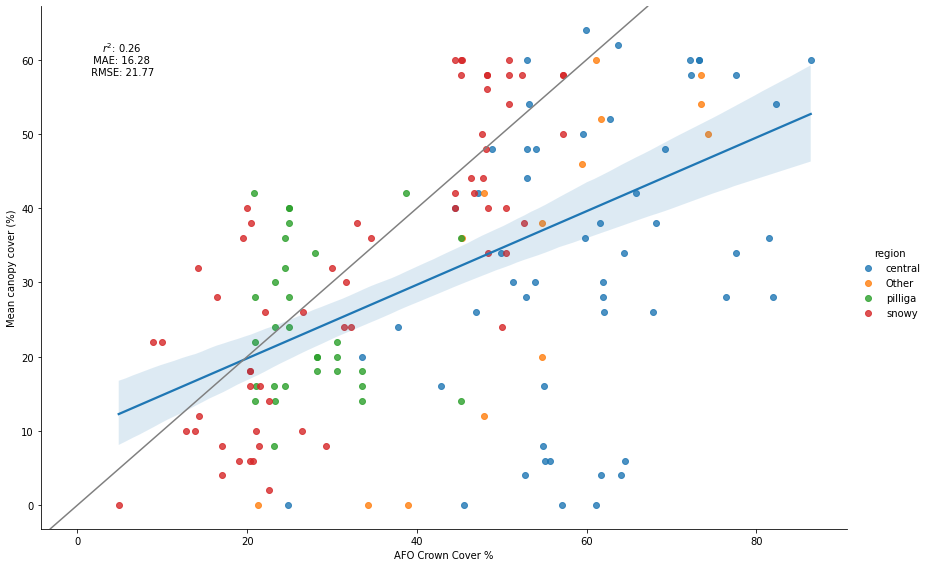

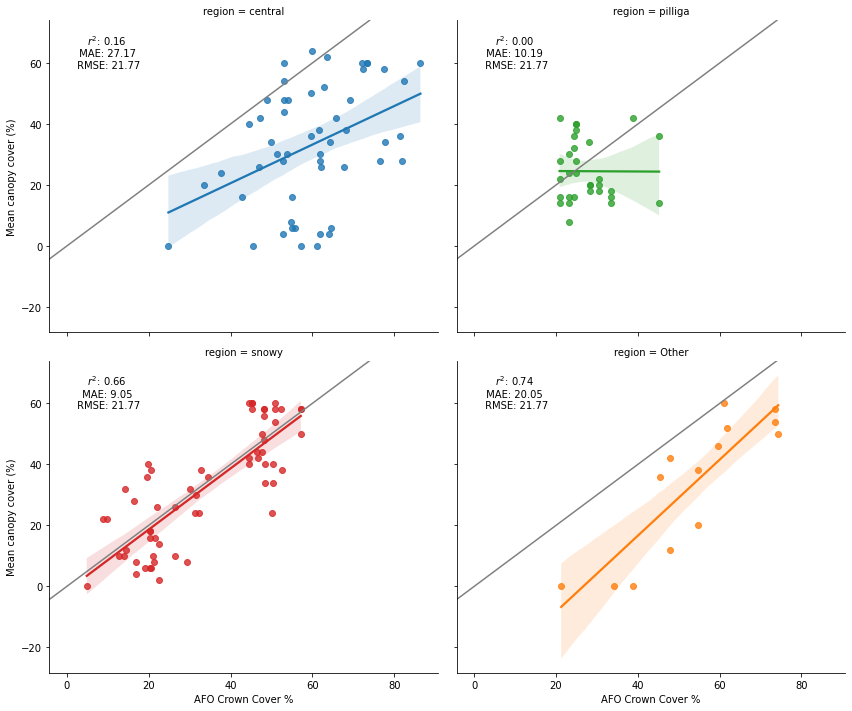

In [21]:
x = 'afo_cc'
y = 'canopy_cov_m'
df = gdf_30
hue='veg_type'
line=True
reg_plot(x, y, df, hue='region', line=line)
plt.show()
reg_plots(x, y, df, hue='region', line=line)
plt.show()

In [20]:
#dump the cleaned dataframe to a csv
gdf.to_csv('AFO_validation_data_20220401.csv')